# **Восстановитель**

## Бизнес-постановка задачи


Жилая недвижимость играет ключевую роль в формировании городской среды и функционировании большинства городских процессов. Здания, обладая пространственными и атрибутивными характеристиками, одновременно являются важным источником данных для управления городским хозяйством. Пространственные характеристики позволяют определять расположение зданий в заданной системе координат, а атрибутивные — такие параметры, как этажность, площадь, численность населения и другие.

Эти данные используются в разных бизнес-процессах города, начиная от планирования общественного транспорта и заканчивая проектированием социальной инфраструктуры. Однако из-за разрозненности источников и частых ошибок при объединении информации нередко возникают проблемы с полнотой и достоверностью данных. Пробелы в данных затрудняют анализ и управление процессами, связанными с развитием городской среды, а также интеграцию этих данных в цифровые модели города.

Задача данной работы заключается в разработке подходов к заполнению недостающих данных о жилых зданиях, что позволит улучшить качество анализа и повысить точность принимаемых решений.

## Понимание данных

Данные о жилых зданиях представляют собой сложную структуру, которая включает как количественные, так и категориальные признаки. В практике городского управления часто встречаются три категории недостающих данных, определенные теорией Дональда Рубина:  

- **MCAR (данные, отсутствующие полностью случайным образом):** данные теряются по причинам, не связанным с их характеристиками, например, из-за технического сбоя. Эти данные не вносят систематических искажений, но уменьшают объем доступной выборки.  
- **MAR (данные, отсутствующие случайным образом):** отсутствия данных обусловлены зависимостью от других известных характеристик объекта. Например, отсутствие информации о новых жилых комплексах.  
- **MNAR (данные, отсутствующие не случайно):** пропуски связаны с причинами, которые обусловливают сам процесс их отсутствия. Например, респонденты могут скрывать ответы на определенные вопросы.  

Для решения задачи корректного заполнения недостающих данных требуется учитывать их категорию и использовать подходящие методы. Наиболее распространенные методы включают:  

- Заполнение пропусков медианным, средним или постоянным значением.  
- Использование моделей регрессии и классификации для прогнозирования недостающих данных.  
- Применение концепции множественных вставок, которая предполагает учет неопределенности путем генерации нескольких значений для одного пропущенного значения.  

Важной особенностью рассматриваемых данных является наличие пространственных зависимостей. Например, информация о соседних объектах может существенно улучшить качество прогнозирования. Поэтому в данном подходе необходимо дополнительно использовать производные признаки, которые формируются на основе пространственных отношений. Однаоко их реализация требует значительных вычислительных ресурсов, особенно при обработке больших объемов данных.

Для лучшего понимания структуры данных жилых зданий приведем пример файла, содержащего информацию о жилых зданиях в Санкт-Петербурге.

In [30]:
!gdown 1-j4eBqnPy4xuYE8YweEMdPX24tgD1wCt # файл с реальными данными о жилых зданиях в СПБ

Downloading...
From: https://drive.google.com/uc?id=1-j4eBqnPy4xuYE8YweEMdPX24tgD1wCt
To: /content/living_building_spb.geojson
100% 36.0M/36.0M [00:00<00:00, 46.6MB/s]


In [31]:
import geopandas as gpd

dataset_path = '/content/living_building_spb.geojson'
buildings_data = gpd.read_file(dataset_path)

buildings_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 12867 entries, 0 to 12866
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   floors       12867 non-null  float64 
 1   living_area  12867 non-null  float64 
 2   area         12867 non-null  float64 
 3   population   12867 non-null  int32   
 4   gascentral   12867 non-null  object  
 5   hotwater     12867 non-null  object  
 6   electricity  12867 non-null  object  
 7   lift         12867 non-null  float64 
 8   index        12867 non-null  int32   
 9   geometry     12867 non-null  geometry
dtypes: float64(4), geometry(1), int32(2), object(3)
memory usage: 904.8+ KB


In [32]:
buildings_data.sample(3)

,floors,living_area,area,population,gascentral,hotwater,electricity,lift,index,geometry
7497,5.0,3797.72,4065.410036,101,1,0,1,0.0,7497,"MULTIPOLYGON (((30.35288 59.91809, 30.35299 59..."
7517,5.0,1005.90,1995.717022,83,1,0,1,1.0,7517,"MULTIPOLYGON (((30.35314 59.91301, 30.35318 59..."
12611,10.0,10346.60,7229.126878,353,0,1,1,5.0,12611,"MULTIPOLYGON (((29.96054 60.0814, 29.9608 60.0..."


Каждый объект в этом файле характеризуется следующими атрибутами:

1. **floors** (числовой) — этажность здания.  
2. **living_area** (числовой) — жилая площадь здания, м².  
3. **area** (числовой) — общая площадь здания, м².  
4. **population** (числовой) — численность проживающего населения.  
5. **gascentral** (категориальный) — наличие центрального газоснабжения (да/нет).  
6. **hotwater** (категориальный) — наличие горячего водоснабжения (да/нет).  
7. **electricity** (категориальный) — наличие электричества (да/нет).  
8. **lift** (категориальный) — наличие лифта (да/нет).

Посмотрим также, как это выглядит на карте:

In [33]:
import folium
import pandas as pd
from IPython.display import display

# Создание карты
def create_map(data, attribute, zoom_area):
    # Инициализация карты в центре заданного региона
    m = folium.Map(location=zoom_area, zoom_start=14, tiles=None)

    # Добавление темной подложки
    folium.TileLayer('CartoDB Dark_Matter').add_to(m)

    # Функция для определения цвета здания
    def get_color(row):
        return 'red' if pd.isnull(row[attribute]) else 'green'

    # Добавление зданий на карту
    for _, row in data.iterrows():
        color = get_color(row)
        folium.GeoJson(
            row['geometry'],
            style_function=lambda feature, color=color: {
                'fillColor': color,
                'color': color,
                'weight': 0.5,
                'fillOpacity': 0.7
            }
        ).add_to(m)
    return m

# Увеличенная область (координаты нужно уточнить для желаемого участка)
zoom_area = [59.934280, 30.335099]  # Центр Санкт-Петербурга

In [ ]:
buildings_map = create_map(buildings_data, 'floors', zoom_area)
display(buildings_map)

Рассматриваемый файл был собран вручную и не содержит пропусков, что гарантирует его высокую достоверность. Эти данные обеспечивают основу для анализа состояния городской среды и разработки управленческих решений.

При этом этажность является ключевым параметром, поскольку она:
- **Коррелирует с плотностью населения.** Знание этажности позволяет оценить возможное количество жильцов в здании.
- **Определяет нагрузку на инфраструктуру.** Здания разной высоты требуют различных ресурсов для обеспечения водой, электричеством, отоплением.
- **Влияет на транспортные и социальные модели.** Например, этажность влияет на потребности в общественном транспорте и объектах социальной инфраструктуры (школы, больницы).
- **Связана с типологией зданий.** Низкоэтажные и высотные здания имеют разные стандарты благоустройства, что также влияет на расчет доступности ресурсов.

## Подготовка данных


Для решения задачи восстановления пропусков был разработан специальный инструмент – класс `DataImputer`. Он доступен в репозитории [GitHub](https://github.com/Jesusya-26/data_imputer). Этот класс предоставляет широкие возможности для работы с пропусками, включая:

- **Имитация пропусков** в данных.  
- **Поиск соседей** для восстановления значений.  
- **Множественную вставку пропусков** с использованием параллельного обучения модели или предварительно обученной модели.  
- **Расчет качественных метрик**, чтобы оценить точность восстановленных данных.  

Для использования `DataImputer` необходимо настроить его конфигурацию, включающую три файла:  
1. **`config_imputation.json`**: Опции для работы с пропусками, включая количество итераций, стратегию начального заполнения и параметры поиска соседей.  
2. **`config_learning.json`**: Настройка пайплайна обработки данных и сетки гиперпараметров для машинного обучения, используемых в алгоритме `HalvingGridSearch`.  
3. **`config_prediction.json`**: Указание пути к ранее обученным моделям, которые можно использовать для предсказания пропусков.  

Для начала установим библиотеку `DataImputer` из репозитория:

In [35]:
!pip install git+https://github.com/Jesusya-26/data_imputer.git

  Cloning https://github.com/Jesusya-26/data_imputer.git to /tmp/pip-req-build-rfbesmgx
  Running command git clone --filter=blob:none --quiet https://github.com/Jesusya-26/data_imputer.git /tmp/pip-req-build-rfbesmgx
  Resolved https://github.com/Jesusya-26/data_imputer.git to commit 35a590558baad601fdb868ad7f4d54a729e883f3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Создадим необходимые папки для работы с инструментом, а также загрузим конфигурационные файлы:

После выполнения этих шагов библиотека будет готова к использованию, а настройки – к применению для восстановления данных.


In [36]:
!mkdir data_imputer && mkdir data_imputer/imputed_data && mkdir data_imputer/quality_score && mkdir data_imputer/simulations
!gdown --folder 1AQvIdV8azcsRVvCerf5lk2-1QM88itP4 -O /content/data_imputer/  # файлы конфигурации

mkdir: cannot create directory ‘data_imputer’: File exists
Retrieving folder contents
Processing file 16JBbkrPULwN9VxVjhW6IBFfkietLYaYf config_imputation.json
Processing file 19VpykbO0vPq7TiRRSNQQoGvjFWGGixFm config_learning.json
Processing file 1Qfg7MyCi7ql970RIXiQadzBfkx5Mk1Kk config_prediction.json
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=16JBbkrPULwN9VxVjhW6IBFfkietLYaYf
To: /content/data_imputer/config/config_imputation.json
100% 324/324 [00:00<00:00, 1.22MB/s]
Downloading...
From: https://drive.google.com/uc?id=19VpykbO0vPq7TiRRSNQQoGvjFWGGixFm
To: /content/data_imputer/config/config_learning.json
100% 1.27k/1.27k [00:00<00:00, 4.52MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Qfg7MyCi7ql970RIXiQadzBfkx5Mk1Kk
To: /content/data_imputer/config/config_prediction.json
100% 83.0/83.0 [00:00<00:00, 286kB/s]
Download completed


Теперь, когда библиотека `DataImputer` готова к использованию, мы можем приступить к созданию датасета с пропусками и последующей его обработке. Рассмотрим основные шаги.

Для начала сымитируем пропуски в файле с жилыми зданиями Санкт-Петербурга. Будем использовать функцию `simulation_omission()` из класса `DataImputer`. Пусть в сгенерированном датасете будет отсутствовать 15% данных по выбранным столбцам:

In [37]:
from data_imputer import DataImputer

# Инициализация объекта класса DataImputer
imputer = DataImputer(dataset_path)

In [38]:
# Симуляция пропусков (15% данных в указанных столбцах)
imputer.simulation_omission(
    damage_degree=15,
    selected_columns=["floors", "living_area", "population", "gascentral", "hotwater", "electricity"],  # выберем наиболее интересные для нас столбцы
    save=True,
)

Проверим, что пропуски действительно есть, и их процент соответствует заданному:

In [39]:
imputer.data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 12867 entries, 0 to 12866
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   floors       10895 non-null  Int64   
 1   living_area  10913 non-null  Float64 
 2   area         12867 non-null  Float64 
 3   population   10938 non-null  Int32   
 4   gascentral   10937 non-null  Int32   
 5   hotwater     10964 non-null  Int32   
 6   electricity  10905 non-null  Int32   
 7   lift         12867 non-null  Int64   
 8   geometry     12867 non-null  geometry
dtypes: Float64(2), Int32(4), Int64(2), geometry(1)
memory usage: 854.4 KB


И посмотрим, как теперь выглядит карта:

In [ ]:
missing_map = create_map(imputer.data, 'floors', zoom_area)
display(missing_map)

После выполнения кода создается модифицированный файл с пропущенными значениями, сохраненный в заранее заданной папке (`data_imputer/simulations`).

Далее найдем ближайших соседей для каждого объекта. Это позволит использовать информацию о соседних объектах для восстановления значений. Метод `add_neighbors_features()` добавляет несколько новых столбцов с суффиксом `_neigh`, в которых будут содержаться усредненные значения соседей:

In [41]:
imputer.add_neighbors_features()

Search for neighbors: 100%|██████████| 12867/12867 [00:39<00:00, 327.68it/s]


Проверим, что получилось:

In [42]:
imputer.data.sample(3)

,floors,living_area,area,population,gascentral,hotwater,electricity,lift,geometry,floors_neigh,living_area_neigh,area_neigh,population_neigh,gascentral_neigh,hotwater_neigh,electricity_neigh,lift_neigh,dist
index,,,,,,,,,,,,,,,,,,
8408,<NA>,2824.7,3172.984444,<NA>,1,1,1,4,"MULTIPOLYGON (((30.37046 59.93056, 30.37074 59...",5.5,6847.835,8654.628386,318.0,1.0,1.0,1.0,3.666667,0.001089
10241,5,3770.6,694.382489,236,1,0,1,0,"MULTIPOLYGON (((30.41905 59.89237, 30.41954 59...",5.0,3393.8,3112.959755,226.0,1.0,0.0,1.0,0.0,0.000892
8402,4,1629.1,262.904904,102,0,<NA>,0,0,"MULTIPOLYGON (((30.3704 59.94919, 30.3704 59.9...",6.0,14130.85,7639.042422,439.333333,1.0,1.0,1.0,6.333333,0.002075


Перед моделированием входные данные проходят подготовку:
1. **Категориальные признаки бинаризуются**, превращаясь в набор индикаторных переменных.  
2. **Пропущенные значения** фиксируются в переменной `nans_position`.  
3. На месте пропусков инициализируются исходные значения, которые заменяются прогнозируемыми.

Для начального заполнения пропусков используется метод `zero_impute()`, поддерживающий несколько стратегий:
- **`distance_weighted`**: заполнение значениями, усредненными с учетом расстояний до соседей.
- **`mean`**: заполнение средними значениями.
- **`median`**: заполнение медианными значениями.

Метод `zero_impute` обеспечивает гибкость и поддерживает несколько стратегий восстановления пропусков. Его основные этапы включают:
1. Проверку корректности переданного метода заполнения.  
2. Реализацию выбранной стратегии заполнения (по весу расстояния или статистическим методам).  
3. Приведение типов данных после заполнения для сохранения структуры исходного датасета.  

Код метода выглядит следующим образом:

```python
def zero_impute(self, impute_method: str) -> GeoDataFrame:
    """
    Восстановление пропусков в GeoDataFrame указанным методом.

    Параметры:
    - impute_method (str): Метод заполнения ("distance_weighted", "mean", "median").

    Возвращает:
    - GeoDataFrame: Измененный GeoDataFrame с восстановленными значениями.

    Исключения:
    - ValueError: Если указан не поддерживаемый метод заполнения.
    """
    if impute_method not in SUPPORTED_METHODS:
        raise NotImplementedError(
            f"Метод '{impute_method}' не поддерживается."
        )

    if impute_method == DISTANCE_WEIGHTED:
        data_with_initial_vals = utils.calculate_distance_weighted_values(
            self.data, self.nans_position
        )
    else:
        data_with_initial_vals = utils.calculate_statistics(
            self.data, impute_method
        )

    try:
        data_with_initial_vals = utils.set_initial_dtypes(
            self.dtypes, data_with_initial_vals
        )
    except Exception as e:
        raise ValueError(f"Ошибка при установке типов данных: {e}") from e

    return data_with_initial_vals
```

После выполнения всех шагов мы получаем датасет, который готов к моделированию. Пропуски заполнены исходными значениями, соседние объекты добавлены как дополнительные признаки, а данные приведены к единому формату для последующего анализа.

## Моделирование

Подробно опишем алгоритм моделирования (1-2 пункты уже упоминались в прошлой главе, но для полноты картины повторим их):

1. **Предварительная обработка данных.** Как уже было сказано, на первом этапе входные данные подвергаются предварительной обработке: категориальные признаки преобразуются в бинарные, а известные значения приводятся к числовому типу. Позиции пропущенных значений записываются в новую переменную. На их месте инициализируются исходные значения, которые впоследствии заменяются прогнозируемыми. Изначальные значения представляют собой средневзвешенные по расстоянию значения от других объектов либо средние/медианные значения по столбцам (в зависимости от конфигурации).  

2. **Расширение исходного пространства признаков (поиск соседей).** Для каждого объекта из входного набора данных в метрическом пространстве выполняется поиск K-ближайших соседей в заданном радиусе \(r\), основанный на Евклидовом расстоянии, измеренном между центрами объектов. Результатом поиска являются две матрицы, содержащие индексы ближайших соседей и расстояния до них для каждого объекта выборки. Полученные индексы используются для вычисления средних значений соседних объектов, которые добавляются к исходному массиву данных. Если используются дополнительные данные (например, рассчитанные пространственные индексы территориальных единиц), они агрегируются и присоединяются к исходному набору данных по заданному атрибуту (например, идентификатору здания или квартала).  

3. **Инициализация моделирования.** Импутация пропущенных значений на каждой итерации начинается с выбора зависимой и независимых переменных в подготовленных данных. Зависимой переменной становится первый по порядку признак, содержащий пропуски в исходном наборе данных. Затем из данных формируется обучающая выборка, состоящая из объектов, у которых по данному признаку отсутствуют пропуски.  

4. **Обучение моделей.** На сформированной выборке обучаются модели регрессии или классификации. Подбор гиперпараметров, обеспечивающих наилучшие прогнозные возможности метода, выполняется с использованием метода **Grid Search с последовательным отсечением** (Successive Halving). Оценка качества модели, обученной с определенной комбинацией гиперпараметров, проводится с помощью **k-кратной перекрестной проверки** (k-fold cross-validation). В качестве функции потерь для регрессионных моделей используется **среднеквадратичная ошибка** (Mean Square Error), а для классификационных моделей — функция **логарифмических потерь** (Log Loss). Прогнозирование пропущенных значений выполняется на основе наилучшей комбинации гиперпараметров, а рассчитанные значения заполняют пропуски.  

5. **Циклическая импутация.** После заполнения пропусков зависимой переменной шаги 3 и 4 повторяются циклически для каждой переменной, содержащей пропуски.  

6. **Полная итерация.** Шаги 3–5 составляют одну полную итерацию импутации данных, общее количество которых задается пользователем, исходя из доступных вычислительных ресурсов. Эмпирически было установлено, что, начиная с двух итераций, коэффициенты моделей становятся стабильными, что позволяет избежать зависимости результата от порядка назначения целевых переменных.  

7. **Финальный результат.** Результатом шагов 1–6 становится полный набор данных, содержащий импутированные значения. В рамках концепции множественной импутации данные обрабатываются несколько раз (от 3 до 5 раз достаточно), после чего значения в независимо обработанных наборах данных усредняются. Выходом метода является финальный набор данных и средний показатель качества, полученный на этапе перекрестной проверки в шаге 4.  

Данный алгоритм реализован в следующих методах класса **DataImputer**:

- **multiple_imputation** – этот метод используется для выполнения множественной импутации с обучением моделей. Он проводит весь процесс, включая предварительную обработку данных, поиск ближайших соседей, обучение моделей, настройку гиперпараметров и многократную импутацию данных.
- **impute_by_saved_models** – этот метод используется, когда необходимо выполнить импутацию, используя уже обученные модели. Он позволяет избежать затратного процесса обучения, что делает его более подходящим для работы с большими объемами данных. Путь к обученным моделям указывается в `config_prediction.json`.

Поскольку процесс обучения моделей может занять значительное время и требует существенных вычислительных ресурсов, более удобным вариантом является использование заранее обученных моделей. Для этого скачаем уже готовые модели и воспользуемся ими для импутации данных.


In [43]:
!gdown --folder 1P7j6zXdqnA1q4uioEODOkvR4ftOf9Oq_ -O /content/data_imputer/fitted_model/  # предобученные модели

Retrieving folder contents
Processing file 17TZs-26F087p3q_HP01YKVbpS5w8eUaL electricity_GBDT.joblib
Processing file 18Qtqhf3CZpycL70gBLFvIe-aGqDXRnrf floors_GBDT.joblib
Processing file 13AZgKY7LhMtLX6gsBlOmiudXM9Kmy7-D gascentral_GBDT.joblib
Processing file 1drBJ8nt89LdXgx5xxxpCYQmwTauKAZhL hotwater_GBDT.joblib
Processing file 1bBlvcK4C_OMP98RDXcM1PF70NQkm_QvK living_area_GBDT.joblib
Processing file 1e0Y1PRagcBoa9kGJU5FLNgOTtP1ECQxR population_GBDT.joblib
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=17TZs-26F087p3q_HP01YKVbpS5w8eUaL
To: /content/data_imputer/fitted_model/living_building_spb_200125_160831_1/electricity_GBDT.joblib
100% 561k/561k [00:00<00:00, 105MB/s]
Downloading...
From: https://drive.google.com/uc?id=18Qtqhf3CZpycL70gBLFvIe-aGqDXRnrf
To: /content/data_imputer/fitted_model/living_building_spb_200125_160831_1/floors_GBDT.joblib
100% 272k/272k [00:00<00:00, 81

Загрузив обученные модели, мы можем использовать метод **impute_by_saved_models** для импутации пропущенных значений. Это позволяет значительно ускорить процесс обработки данных, так как все необходимые модели уже были обучены заранее.

In [44]:
imputer.impute_by_saved_models()

Iteration of Imputation: 100%|██████████| 12/12 [00:01<00:00,  6.26it/s]


,floors,living_area,area,population,gascentral,hotwater,electricity,lift,geometry
index,,,,,,,,,
0,12,10971.71,6730.086609,634,0,1,1,7,"MULTIPOLYGON (((29.72626 60.00963, 29.72605 60..."
1,12,23013.9,213.080076,1201,0,1,1,12,"POLYGON ((30.42553 59.83625, 30.42541 59.83622..."
2,7,5251.27,4844.486082,0,1,0,1,3,"POLYGON ((30.31293 59.96774, 30.31287 59.96761..."
3,5,6462.12,9618.118033,379,1,0,1,0,"POLYGON ((30.34014 59.92708, 30.34083 59.92756..."
4,5,5137.29,8207.053031,194,1,1,1,5,"POLYGON ((30.3673 59.93019, 30.36738 59.93016,..."
...,...,...,...,...,...,...,...,...,...
12862,7,6160.7,4403.261532,403,1,1,0,2,"MULTIPOLYGON (((30.58217 59.7331, 30.58221 59...."
12863,7,13650.11,8422.950234,880,1,1,1,7,"MULTIPOLYGON (((30.5866 59.73203, 30.58663 59...."
12864,5,3401.5,5497.241805,147,0,1,0,3,"MULTIPOLYGON (((30.61266 59.74185, 30.61397 59..."


Проверим, что данные действительно восстановлены:

In [45]:
imputer.imputed_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 12867 entries, 0 to 12866
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   floors       12867 non-null  Int64   
 1   living_area  12867 non-null  Float64 
 2   area         12867 non-null  Float64 
 3   population   12867 non-null  Int32   
 4   gascentral   12867 non-null  Int32   
 5   hotwater     12867 non-null  Int32   
 6   electricity  12867 non-null  Int32   
 7   lift         12867 non-null  Int64   
 8   geometry     12867 non-null  geometry
dtypes: Float64(2), Int32(4), Int64(2), geometry(1)
memory usage: 1.2 MB


## Оценка

Для оценки качества восстановления данных в классе DataImputer предусмотрен метод `get_quality_metrics()`. Он позволяет вычислить значения ошибок для категориальных и числовых признаков, используя заданные метрики.

* Log Loss используется для оценки качества восстановления категориальных данных.
* Mean Absolute Error (MAE) применяется для числовых данных и отражает среднюю абсолютную ошибку между реальными и восстановленными значениями.

Можно установить и любые другие метрики.

In [46]:
from sklearn.metrics import log_loss, mean_absolute_error

In [47]:
# Оценка качества восстановления
quality = imputer.get_quality_metrics(
    classification_metric=log_loss,
    regression_metric=mean_absolute_error
)
quality

{'floors': 3.6460446247464504,
 'living_area': 4694.2666366057,
 'population': 348.7407983411094,
 'gascentral': 9.729918868253904,
 'hotwater': 13.656055750684953,
 'electricity': 33.931002961110785}

Для числовых признаков, таких как количество этажей здания, полезно визуализировать распределение ошибок. Например, построим гистограмму для признака `floors`:

In [48]:
import matplotlib.pyplot as plt

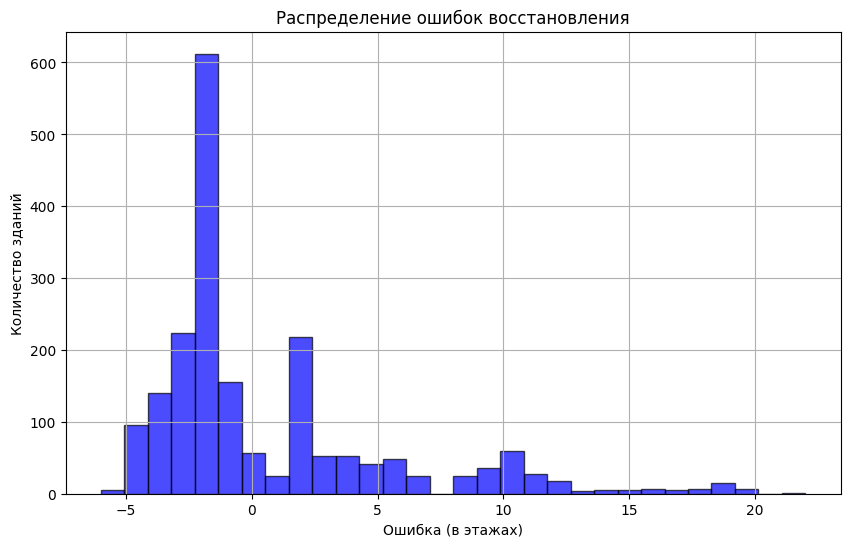

In [49]:
data_real = imputer.input_data.copy()
data_real['error'] = imputer.input_data.loc[imputer.nans_position['floors'], 'floors'] - imputer.imputed_data.loc[imputer.nans_position['floors'], 'floors']

plt.figure(figsize=(10, 6))
plt.hist(data_real['error'].dropna(), bins=30, color='blue', edgecolor='black', alpha=0.7)
plt.title("Распределение ошибок восстановления")
plt.xlabel("Ошибка (в этажах)")
plt.ylabel("Количество зданий")
plt.grid(True)
plt.show()

Как видим, в среднем модель ошибается на 2-4 этажа, что в целом удовлетворительно на текущем этапе. Также на гистограмме можно наблюдать крайне экстремальные выбросы (почти 30 этажей), что, вероятно, связано с отсутствием данных о соседях или критическим различием в этажности.

Для анализа ошибок восстановления в геопространственном контексте создадим карту, на которой цвет зданий будет зависеть от величины ошибки восстановления. Зелёный цвет указывает на точное совпадение, красный — на максимальное отклонение, а серый — на отсутствие данных.

In [53]:
# Функция для создания карты ошибок
def create_error_map(data, zoom_area):
    m = folium.Map(location=zoom_area, zoom_start=14, tiles="CartoDB Dark_Matter")

    # Нормализация ошибки для цветовой карты
    max_abs_error = data['error'].abs().max()
    def get_color(row):
        if pd.isnull(row['error']):
            return 'gray'  # если значение отсутствует
        norm_error = abs(row['error']) / max_abs_error
        # Зелёный для низкой ошибки, красный для высокой
        return f"#{int(255 * norm_error):02x}{int(255 * (1 - norm_error)):02x}00"

    # Добавление зданий на карту
    for _, row in data.iterrows():
        color = get_color(row)
        folium.GeoJson(
            row['geometry'],
            style_function=lambda feature, color=color: {
                'fillColor': color,
                'color': color,
                'weight': 0.5,
                'fillOpacity': 0.7
            }
        ).add_to(m)
    return m

In [ ]:
data_real = imputer.input_data.copy()
data_real['error'] = imputer.input_data['floors'] - imputer.imputed_data['floors']

error_map = create_error_map(data_real, zoom_area)
display(error_map)

Анализируя данную карту, мы можем убедиться в том, что в целом модель отработала удовлетворительно.

## Развёртывание

Для достижения более высокой точности восстановления данных и минимизации выбросов важно использовать дополнительные источники информации и улучшать методику обработки данных. Можно использовать следующие подходы:

### 4.1. Сравнение геометрий зданий

Одним из эффективных способов улучшить восстановление пропущенных атрибутов является анализ геометрии зданий. Геометрия включает форму, площадь, периметр и другие пространственные характеристики. Например:

- **Форма и площадь:** У зданий с похожей геометрией часто совпадают такие атрибуты, как количество этажей, тип использования или год постройки. Анализ этих данных позволит уточнить значения для зданий с пропусками.
- **Плотность застройки:** Сравнение объектов в зависимости от их расположения на плотно застроенной территории или в более свободной зоне может дать подсказки о характере зданий.

### 4.2. Использование космических снимков

Космические снимки предоставляют богатый источник информации, который может быть использован для уточнения признаков зданий. Из снимков можно извлечь:
- Цветовые характеристики, которые коррелируют с материалами крыш.
- Высотные данные, доступные с помощью стереопар или LiDAR-съемки.
- Тип ландшафта вокруг здания, который может указывать на функциональное назначение.

### 4.3. Использование временных данных

Исторические данные о зданиях, такие как временные снимки или динамика застройки, могут быть полезны для уточнения атрибутов:
- Анализ изменений зданий во времени позволяет учитывать реконструкции и модификации.
- Привязка данных к годам съемки дает контекст для анализа исторических признаков (например, этажность).

### 4.4. Интеграция данных о зонах и инфраструктуре

Контекстные данные о зоне, в которой расположено здание, также могут улучшить восстановление:
- **Тип застройки:** жилые, коммерческие, промышленные зоны.
- **Данные о дорогах и инфраструктуре:** здания вблизи крупных транспортных узлов чаще имеют более высокую этажность.
- **Близость к зелёным зонам или воде:** влияет на архитектурные решения.

Эти подходы требуют дополнительных ресурсов, однако их использование позволит значительно снизить ошибки восстановления данных и минимизировать выбросы.

Для того чтобы убедиться в том, насколько успешно работает модель, проверим её работу на датасетах с 30 и 50 процентами пропущенных данных.

### 30%

In [55]:
from data_imputer import DataImputer

# Инициализация объекта класса DataImputer
imputer_30 = DataImputer(dataset_path)

In [56]:
# Симуляция пропусков (30% данных в указанных столбцах)
imputer_30.simulation_omission(
    damage_degree=30,
    selected_columns=["floors", "living_area", "population", "gascentral", "hotwater", "electricity"],  # выберем наиболее интересные для нас столбцы
    save=True,
)

In [57]:
imputer_30.data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 12867 entries, 0 to 12866
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   floors       8974 non-null   Int64   
 1   living_area  9022 non-null   Float64 
 2   area         12867 non-null  Float64 
 3   population   9053 non-null   Int32   
 4   gascentral   8928 non-null   Int32   
 5   hotwater     8949 non-null   Int32   
 6   electricity  8948 non-null   Int32   
 7   lift         12867 non-null  Int64   
 8   geometry     12867 non-null  geometry
dtypes: Float64(2), Int32(4), Int64(2), geometry(1)
memory usage: 854.4 KB


In [ ]:
missing_30_map = create_map(imputer_30.data, 'floors', zoom_area)
display(missing_30_map)

In [59]:
imputer_30.add_neighbors_features()

Search for neighbors: 100%|██████████| 12867/12867 [00:38<00:00, 336.26it/s]


In [60]:
imputer_30.impute_by_saved_models()

Iteration of Imputation: 100%|██████████| 12/12 [00:02<00:00,  5.74it/s]


,floors,living_area,area,population,gascentral,hotwater,electricity,lift,geometry
index,,,,,,,,,
0,6,10971.71,6730.086609,634,0,1,1,7,"MULTIPOLYGON (((29.72626 60.00963, 29.72605 60..."
1,6,23013.9,213.080076,1201,0,1,1,12,"POLYGON ((30.42553 59.83625, 30.42541 59.83622..."
2,7,5251.27,4844.486082,0,1,0,1,3,"POLYGON ((30.31293 59.96774, 30.31287 59.96761..."
3,5,6462.12,9618.118033,379,1,0,1,0,"POLYGON ((30.34014 59.92708, 30.34083 59.92756..."
4,5,5137.29,8207.053031,0,1,1,1,5,"POLYGON ((30.3673 59.93019, 30.36738 59.93016,..."
...,...,...,...,...,...,...,...,...,...
12862,7,6160.7,4403.261532,0,1,1,1,2,"MULTIPOLYGON (((30.58217 59.7331, 30.58221 59...."
12863,7,4865.283154,8422.950234,0,1,1,1,7,"MULTIPOLYGON (((30.5866 59.73203, 30.58663 59...."
12864,5,5185.239505,5497.241805,147,0,1,1,3,"MULTIPOLYGON (((30.61266 59.74185, 30.61397 59..."


In [61]:
# Оценка качества восстановления
quality = imputer_30.get_quality_metrics(
    classification_metric=log_loss,
    regression_metric=mean_absolute_error
)
quality

{'floors': 3.718725918314924,
 'living_area': 4584.326524967398,
 'population': 360.2165705296277,
 'gascentral': 9.562228431487034,
 'hotwater': 12.511324300459243,
 'electricity': 33.532829869028106}

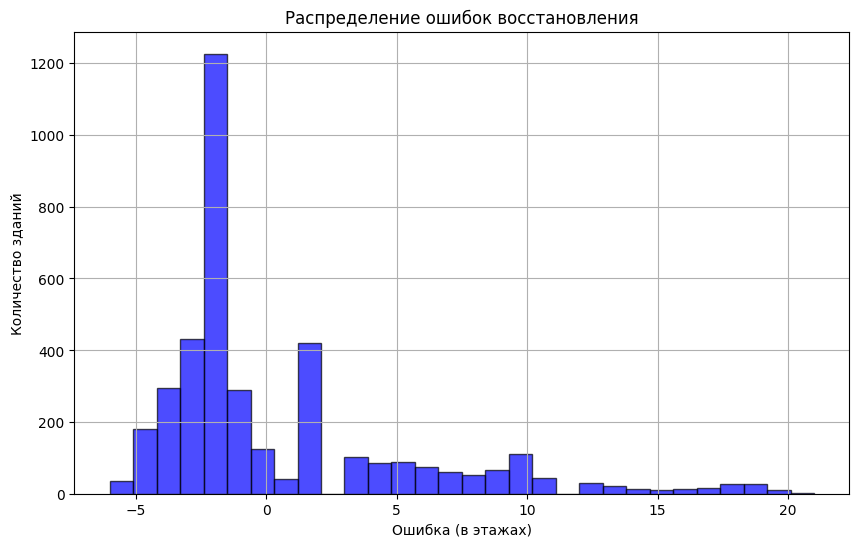

In [62]:
data_real = imputer_30.input_data.copy()
data_real['error'] = imputer_30.input_data.loc[imputer_30.nans_position['floors'], 'floors'] - imputer_30.imputed_data.loc[imputer_30.nans_position['floors'], 'floors']

plt.figure(figsize=(10, 6))
plt.hist(data_real['error'].dropna(), bins=30, color='blue', edgecolor='black', alpha=0.7)
plt.title("Распределение ошибок восстановления")
plt.xlabel("Ошибка (в этажах)")
plt.ylabel("Количество зданий")
plt.grid(True)
plt.show()

In [ ]:
data_real = imputer_30.input_data.copy()
data_real['error'] = imputer_30.input_data['floors'] - imputer_30.imputed_data['floors']

error_map = create_error_map(data_real, zoom_area)
display(error_map)

Таким образом, мы убедились в том, что для датасета с 30% пропущенных данных модель отрабатывает примерно с тем же успехом, что и для 15 процентов.

### 50%

In [73]:
from data_imputer import DataImputer

# Инициализация объекта класса DataImputer
imputer_50 = DataImputer(dataset_path)

In [74]:
# Симуляция пропусков (50% данных в указанных столбцах)
imputer_50.simulation_omission(
    damage_degree=50,
    selected_columns=["floors", "living_area", "population", "gascentral", "hotwater", "electricity"],  # выберем наиболее интересные для нас столбцы
    save=True,
)

In [75]:
imputer_50.data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 12867 entries, 0 to 12866
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   floors       6429 non-null   Int64   
 1   living_area  6419 non-null   Float64 
 2   area         12867 non-null  Float64 
 3   population   6444 non-null   Int32   
 4   gascentral   6423 non-null   Int32   
 5   hotwater     6352 non-null   Int32   
 6   electricity  6438 non-null   Int32   
 7   lift         12867 non-null  Int64   
 8   geometry     12867 non-null  geometry
dtypes: Float64(2), Int32(4), Int64(2), geometry(1)
memory usage: 854.4 KB


In [ ]:
missing_50_map = create_map(imputer_30.data, 'floors', zoom_area)
display(missing_50_map)

In [77]:
imputer_50.add_neighbors_features()

Search for neighbors: 100%|██████████| 12867/12867 [00:36<00:00, 350.61it/s]


In [78]:
imputer_50.impute_by_saved_models()

Iteration of Imputation: 100%|██████████| 12/12 [00:02<00:00,  5.29it/s]


,floors,living_area,area,population,gascentral,hotwater,electricity,lift,geometry
index,,,,,,,,,
0,7,10971.71,6730.086609,634,1,1,1,7,"MULTIPOLYGON (((29.72626 60.00963, 29.72605 60..."
1,12,6144.084272,213.080076,1201,0,1,0,12,"POLYGON ((30.42553 59.83625, 30.42541 59.83622..."
2,7,5251.27,4844.486082,203,1,0,0,3,"POLYGON ((30.31293 59.96774, 30.31287 59.96761..."
3,7,6462.12,9618.118033,379,1,1,1,0,"POLYGON ((30.34014 59.92708, 30.34083 59.92756..."
4,5,5137.29,8207.053031,0,1,1,0,5,"POLYGON ((30.3673 59.93019, 30.36738 59.93016,..."
...,...,...,...,...,...,...,...,...,...
12862,9,4926.08746,4403.261532,0,1,1,0,2,"MULTIPOLYGON (((30.58217 59.7331, 30.58221 59...."
12863,9,13650.11,8422.950234,0,1,1,0,7,"MULTIPOLYGON (((30.5866 59.73203, 30.58663 59...."
12864,7,5128.606326,5497.241805,147,1,1,1,3,"MULTIPOLYGON (((30.61266 59.74185, 30.61397 59..."


In [79]:
# Оценка качества восстановления
quality = imputer_50.get_quality_metrics(
    classification_metric=log_loss,
    regression_metric=mean_absolute_error
)
quality

{'floors': 3.6761416589002796,
 'living_area': 4560.2211913039255,
 'population': 352.8643935855519,
 'gascentral': 9.883478513123837,
 'hotwater': 13.194798669692156,
 'electricity': 33.745022515025056}

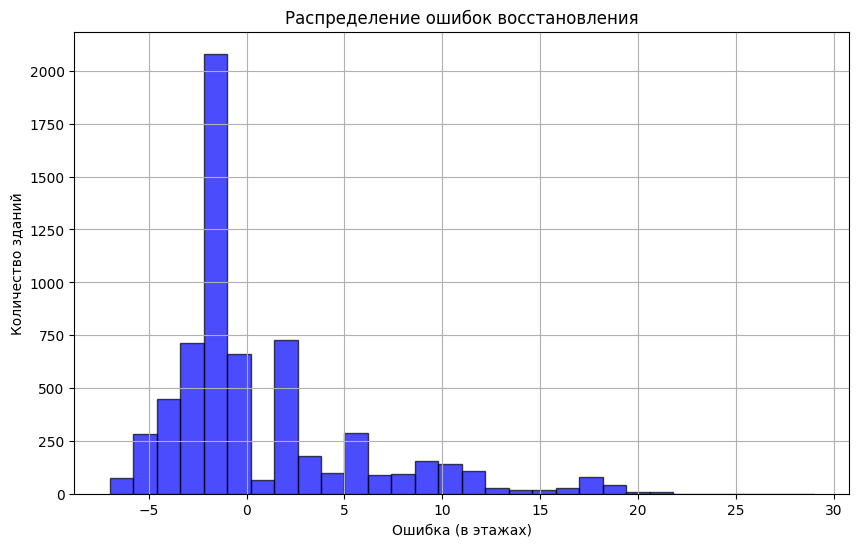

In [80]:
data_real = imputer_50.input_data.copy()
data_real['error'] = imputer_50.input_data.loc[imputer_50.nans_position['floors'], 'floors'] - imputer_50.imputed_data.loc[imputer_50.nans_position['floors'], 'floors']

plt.figure(figsize=(10, 6))
plt.hist(data_real['error'].dropna(), bins=30, color='blue', edgecolor='black', alpha=0.7)
plt.title("Распределение ошибок восстановления")
plt.xlabel("Ошибка (в этажах)")
plt.ylabel("Количество зданий")
plt.grid(True)
plt.show()

In [ ]:
data_real = imputer_50.input_data.copy()
data_real['error'] = imputer_50.input_data['floors'] - imputer_50.imputed_data['floors']

error_map = create_error_map(data_real, zoom_area)
display(error_map)

Таким образом, мы убедились в том, что для датасета с 50% пропущенных данных модель отрабатывает примерно с тем же успехом, что и для 15 процентов.